<h1><center>Project: Imagewoof</center></h1>


# Overview

Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog. (No we will not enter in to any discussion in to whether a dingo is in fact a dog.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Constants-and-variables" data-toc-modified-id="Constants-and-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Constants and variables</a></span></li><li><span><a href="#Additional-Functions" data-toc-modified-id="Additional-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Additional Functions</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Load-and-preprocess-label-file" data-toc-modified-id="Load-and-preprocess-label-file-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load and preprocess label file</a></span></li></ul></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Quantative-analysis" data-toc-modified-id="Quantative-analysis-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Quantative analysis</a></span></li><li><span><a href="#Image-Analysis" data-toc-modified-id="Image-Analysis-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Image Analysis</a></span><ul class="toc-item"><li><span><a href="#General-overview" data-toc-modified-id="General-overview-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>General overview</a></span></li><li><span><a href="#Image-proportions-and-sizes" data-toc-modified-id="Image-proportions-and-sizes-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Image proportions and sizes</a></span></li></ul></li></ul></li><li><span><a href="#Prepare-datasets" data-toc-modified-id="Prepare-datasets-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prepare datasets</a></span><ul class="toc-item"><li><span><a href="#Create-class-for-dataset" data-toc-modified-id="Create-class-for-dataset-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create class for dataset</a></span></li><li><span><a href="#Define-transforms" data-toc-modified-id="Define-transforms-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Define transforms</a></span></li><li><span><a href="#Create-datasets" data-toc-modified-id="Create-datasets-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Create datasets</a></span></li><li><span><a href="#Create-dataloaders" data-toc-modified-id="Create-dataloaders-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Create dataloaders</a></span></li></ul></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Build model</a></span><ul class="toc-item"><li><span><a href="#Load-model" data-toc-modified-id="Load-model-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Load model</a></span></li><li><span><a href="#Define-loss-function-and-optimizer" data-toc-modified-id="Define-loss-function-and-optimizer-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Define loss function and optimizer</a></span></li></ul></li><li><span><a href="#Training-model" data-toc-modified-id="Training-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training model</a></span></li></ul></div>

## Import modules

In [1]:
import os
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import transforms as T
from torchvision import models
from torchmetrics import ConfusionMatrix

import warnings
warnings.filterwarnings("ignore")

## Constants and variables

In [21]:
LABEL_FILE = '../data/noisy_imagewoof.csv'

RADNOM_STATE = 12345

BATCH_SIZE = 64

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

## Additional Functions

In [37]:
# Adding image ratios
def add_ratios(row):
    
    img = np.array(Image.open(os.path.join('../data/', row[0])))
        
    h, w, r, ch = img.shape[0], img.shape[1], img.shape[0]/img.shape[1], len(img.shape) 
    
    return h, w, r, ch

In [24]:
# Display grid of images from label file
def grid_display_images(df, nrows, ncols, figsize):
    
    fig = plt.figure(figsize=figsize)
    
    for i in range(nrows*ncols):

        fig.add_subplot(nrows, ncols, i+1)
        plt.imshow(cv2.imread(os.path.join('../data', df.iloc[i].path)))
        plt.title(df.iloc[i].breed)

    plt.tight_layout()
    plt.show()

In [25]:
# Display grid of images from dataloader
def grid_display_dataloader(dataloader, nrows, ncols, figsize):
        
    fig = plt.figure(figsize=figsize)
    
    for i in range(nrows*ncols):
        fig.add_subplot(nrows, ncols, i+1)
        
        batch = next(iter(dataloader))
        img, target, breed = batch['image'][0], batch['target'][0], batch['breed'][0]
        plt.imshow(unnormalize(img).permute(1,2,0))
        plt.title(f'Class: {target} Breed: {breed}')

    plt.tight_layout()
    plt.show()

In [26]:
# Unnormalize image
def unnormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    
    # To normalize: X_norm = (X - mean) / std
    # To unnormalize: X = (X_norm * std) + mean

    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
        
    return img

In [54]:
# Accuracy score
def accuracy(output, targets):
    return np.count_nonzero((np.argmax(np.array(nn.Softmax(dim=1)(output.cpu()).detach()), axis=1) - np.array(targets.cpu())) == 0) / \
           targets.shape[0]

In [28]:
# Model prediction on single image
def prediction(model, image):

    with torch.no_grad():
        model.eval()

        logits = model(torch.unsqueeze(image, dim=0))
        predict_proba = nn.Softmax()(logits)
        predict = torch.argmax(nn.Softmax()(logits))

    return predict, predict_proba

In [84]:
# Show image and preiction probapilities on single item
def show_single_prediction(model, data):
    
    class_breed_dict = {
                  0:'Australian terrier', 
                  1:'Border terrier', 
                  2:'Samoyed', 
                  3:'Beagle', 
                  4:'Shih-Tzu', 
                  5:'English foxhound', 
                  6:'Rhodesian ridgeback', 
                  7:'Dingo', 
                  8:'Golden retriever', 
                  9:'Old English sheepdog'
                  }

    image, target, breed = data['image'], data['target'], data['breed']

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    
    pred, predict_proba = prediction(model, image.to(device))
    pred_proba_max = round(float(torch.max(predict_proba)), 3)


    fig, ax = plt.subplots(nrows=1, ncols=2, 
                           figsize=(10, 5), 
                           gridspec_kw={'width_ratios': [1, 1]})

    ax[0].figure.set_size_inches(3.5, 3.5)
    ax[1].figure.set_size_inches(3.5*3, 3.5)


    ax[0].imshow(unnormalize(image).permute(1,2,0))
    ax[0].set_title(f'        True breed: {breed}\nPredicted breed: {class_breed_dict[int(pred)]}')

    colors = plt.cm.jet(np.linspace(0,1,10))

    ax[1].vlines(x=list(class_breed_dict.keys()), 
                 ymin=0, ymax=predict_proba.cpu(), color=colors, linewidth=20)

    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Predicted probapility')

    ax[1].set_xticks(np.arange(0, 10, step=1))


    ax[1].set_title(f'True class: {target}     \nPredicted class: {pred} ({pred_proba_max*100}%)')

    ax[1].set_xlim(0, 9)
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

## Load Data

### Load and preprocess label file

In [30]:
labels = pd.read_csv(LABEL_FILE)

display(labels.head())
labels.info()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,n02115641,False
1,train/n02115641/n02115641_843.JPEG,n02115641,n02115641,n02105641,n02115641,n02088364,False
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02115641,n02111889,n02099601,False
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02115641,n02093754,n02115641,False
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02115641,n02088364,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             12954 non-null  object
 1   noisy_labels_0   12954 non-null  object
 2   noisy_labels_1   12954 non-null  object
 3   noisy_labels_5   12954 non-null  object
 4   noisy_labels_25  12954 non-null  object
 5   noisy_labels_50  12954 non-null  object
 6   is_valid         12954 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 620.0+ KB


- We need only columns:
    - path - path to file
    - noisy_labels_0 - label of image
    - is_valid - is image from train or validation dataset

In [31]:
labels = labels[['path', 'noisy_labels_0', 'is_valid']]

- Adding meaningfull labels and class numbers

In [32]:
breeds_dict = {
              'n02093754':'Australian terrier', 
              'n02089973':'Border terrier', 
              'n02099601':'Samoyed', 
              'n02087394':'Beagle', 
              'n02105641':'Shih-Tzu', 
              'n02096294':'English foxhound', 
              'n02088364':'Rhodesian ridgeback', 
              'n02115641':'Dingo', 
              'n02111889':'Golden retriever', 
              'n02086240':'Old English sheepdog'
              }

labels_dict = {label:i for i, label in enumerate(breeds_dict.keys())}
    
labels['breed'] = labels['noisy_labels_0'].map(breeds_dict)
labels['class'] = labels['noisy_labels_0'].map(labels_dict)

labels = labels.drop(columns='noisy_labels_0')

labels.sample(frac=1).head()

,path,is_valid,breed,class
1427,train/n02086240/n02086240_9757.JPEG,False,Old English sheepdog,9
6766,train/n02096294/n02096294_4139.JPEG,False,English foxhound,5
257,train/n02115641/n02115641_5945.JPEG,False,Dingo,7
1503,train/n02086240/n02086240_5325.JPEG,False,Old English sheepdog,9
6778,train/n02096294/n02096294_5745.JPEG,False,English foxhound,5


## Data Analysis

### Quantative analysis

- Some basic statistics

In [33]:
print('Number of image path duplicates: {}\n'.format(sum(labels['path'].duplicated())))
print('Number of images in train set: {}\n'.format(labels[labels['is_valid']==False]['is_valid'].count()))
print('Number of images in valid set: {}\n'.format(labels[labels['is_valid']==True]['is_valid'].count()))
print('Number of categories: {}'.format(len(labels['class'].unique())))

Number of image path duplicates: 0

Number of images in train set: 9025

Number of images in valid set: 3929

Number of categories: 10


- Check balance of classes

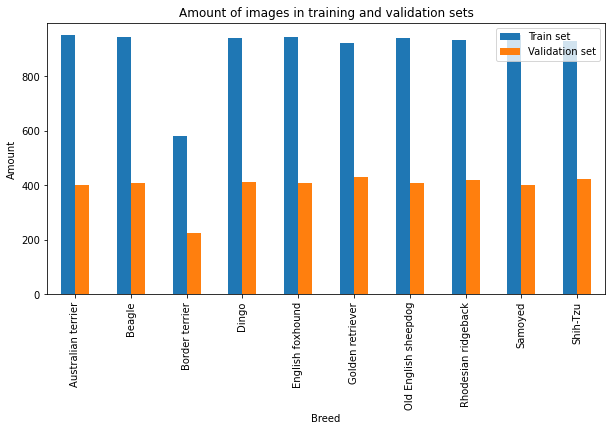

In [34]:
fig, ax = plt.subplots(figsize=(10,5))

pd.pivot_table(labels, index='breed', 
               aggfunc='count', 
               columns=['is_valid'])['class'].plot(kind='bar', 
                                                     ax=ax)
ax.set_xlabel('Breed')
ax.set_ylabel('Amount')
plt.legend(['Train set', 'Validation set'])
plt.title('Amount of images in training and validation sets')
plt.show()

- As we can see from the graph above - all classes are represented equally among the train and validation sets except for 'Border terrier' class, which has ~2/3 of the mean amount of images in other classes

- If this inbalance will be an issue, we could add some images to  'Border terrier' class using augmentations like rotation and vertical flip

### Image Analysis

#### General overview

- Lets check some images from different classes

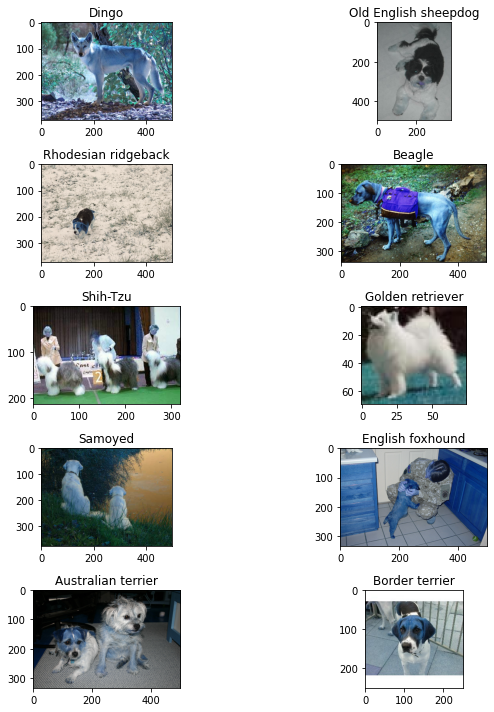

In [35]:
unique_breeds = labels.drop_duplicates('breed')[['path', 'breed']]

grid_display_images(unique_breeds, 5, 2, figsize=(10, 10))

- From the fisrt view we can tell:

    1. Images are of different sizes
    2. Aspect ratio is different
    3. Images have color but not necessary natural
    4. Dogs could have different poses, size
    5. There could be more than one dog on the image

- Following transforms are necessary:

    1. Normalization
    2. Resize

#### Image proportions and sizes 

- Lets analyse how height, width, aspects, number of channels varies within datasets

In [38]:
image_ratios = labels[['path', 'breed', 'is_valid']].copy()
                                         
image_ratios[['Width', 'Height', 'Ratio W/H', 'Channels']] = image_ratios.apply(add_ratios, 
                                                             axis=1, 
                                                             result_type='expand')

In [39]:
image_ratios_df = round(image_ratios[['Width', 'Height', 'Ratio W/H', 'Channels']].describe().iloc[[1, 3, 5, -1]], 1)




Image size and proportions histograms:



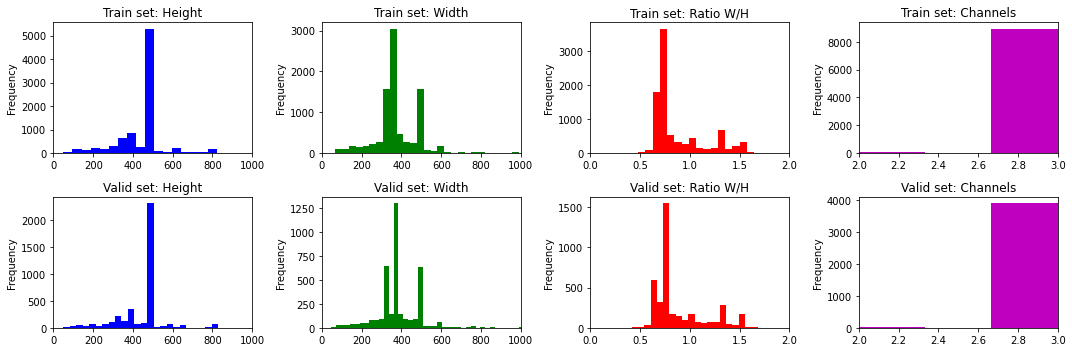


Example of small size images:


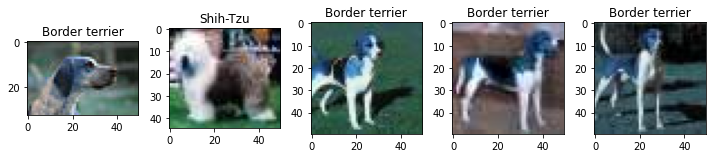


Example of medium size images:


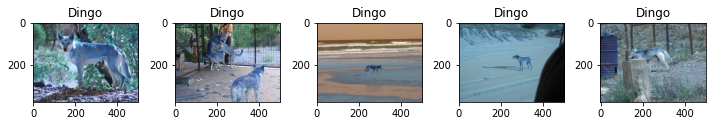


Example of large size images:


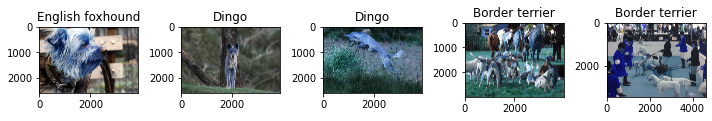

,Width,Height,Ratio W/H,Channels
mean,397.2,470.3,0.9,3.0
min,33.0,50.0,0.3,2.0
50%,375.0,500.0,0.8,3.0
max,3456.0,4608.0,2.4,3.0


In [40]:

# Histograms woth image proportions

print('\nImage size and proportions histograms:\n')

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

image_ratios[image_ratios['is_valid']==False]['Height'].plot(kind='hist', 
                                                        ax=ax[0][0],
                                                        title='Train set: Height',
                                                        xlim=(0, 1000), 
                                                        bins=100, color='b'
                                                       )

image_ratios[image_ratios['is_valid']==False]['Width'].plot(kind='hist', 
                                                        ax=ax[0][1],
                                                        title='Train set: Width',
                                                        xlim=(0, 1000), 
                                                        bins=100, color='g'
                                                       )

image_ratios[image_ratios['is_valid']==False]['Ratio W/H'].plot(kind='hist', 
                                                        ax=ax[0][2],
                                                        title='Train set: Ratio W/H',
                                                        xlim=(0, 2), 
                                                        bins=30, color='r'
                                                       )

image_ratios[image_ratios['is_valid']==False]['Channels'].plot(kind='hist', 
                                                        ax=ax[0][3],
                                                        title='Train set: Channels',
                                                        xlim=(2, 3), 
                                                        bins=3, color='m'
                                                       )


image_ratios[image_ratios['is_valid']==True]['Height'].plot(kind='hist', 
                                                        ax=ax[1][0],
                                                        title='Valid set: Height',
                                                        xlim=(0, 1000), 
                                                        bins=100, color='b'
                                                       )

image_ratios[image_ratios['is_valid']==True]['Width'].plot(kind='hist', 
                                                        ax=ax[1][1],
                                                        title='Valid set: Width',
                                                        xlim=(0, 1000), 
                                                        bins=100, color='g'
                                                       )

image_ratios[image_ratios['is_valid']==True]['Ratio W/H'].plot(kind='hist', 
                                                        ax=ax[1][2],
                                                        title='Valid set: Ratio W/H',
                                                        xlim=(0, 2), 
                                                        bins=30, color='r'
                                                       )

image_ratios[image_ratios['is_valid']==True]['Channels'].plot(kind='hist', 
                                                        ax=ax[1][3],
                                                        title='Valid set: Channels',
                                                        xlim=(2, 3), 
                                                        bins=3, color='m'
                                                       )
plt.tight_layout()
plt.show()


# Image examples

print('\nExample of small size images:')
grid_display_images(image_ratios.sort_values(by=['Height', 'Width']).head(), 1, 5, figsize=(10, 10))

print('\nExample of medium size images:')
grid_display_images(image_ratios.query('Height=='+str(image_ratios_df.loc['50%']['Height'])\
                   + 'and Width=='+str(image_ratios_df.loc['50%']['Width'])).head(), 1, 5, figsize=(10, 10))

print('\nExample of large size images:')
grid_display_images(image_ratios.sort_values(by=['Height', 'Width']).tail(), 1, 5, figsize=(10, 10))


# Image proportions statistics

display(image_ratios_df)

 - Conclusions:

    1. Almaost all images have 3 channels but there is small amount of greyscale ones (with 2 channels)
    2. in general size and proportions are pretty homogenous both in train and validation sets with median values of width - 375, height - 500, aspect ratio 0.8
    3. There is a small amount of size-wise outliers with a range of width-height values varies from 33 to 4608 pixels
    4. Small, medium and large images seems to be appropriate for training
    5. Since dog could appear in any place on image and occupy almost whole picture it will be better not to use center crop and apply standart resizing instead
    6. Height/wegth ratio is close 1 in most cases, so it will be legitimate to use aspect ratio 1 while resizing 

## Prepare datasets

### Create class for dataset

In [41]:
class ImageDataset(Dataset):
    
    def __init__(self, labels, transforms=None, valid=False):
                
        # Select training or validation set
        self.labels = labels[labels['is_valid']==valid]
        
        if transforms:
            self.transforms = transforms
        else:
            self.transforms = None
                
        
    def __getitem__(self, idx):
        
        # Load image        
        img_path = os.path.join('../data/', self.labels.iloc[idx].path)
        
        image = Image.open(img_path)
        
        if len(np.array(image).shape):
            image = image.convert('RGB')
        
        # Apply transforms to image
        if self.transforms:
            image = self.transforms(image)
        else:
            image = T.ToTensor()(image)
        
        # Target class
        target = torch.tensor(self.labels.iloc[idx]['class'], 
                              dtype=torch.long)
        
        # Class breed 
        breed = self.labels.iloc[idx].breed
        
        return {'image':image, 'target':target, 'breed':breed}
        
        
    def __len__(self):
        return len(self.labels)

### Define transforms

In [42]:
transforms = T.Compose([T.Resize(size=(224, 224)), 
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
                       ])

- Since imagewoof is part of ImageNet dataset wew will use normalization recomended mean and std

### Create datasets

In [43]:
train_dataset = ImageDataset(labels, transforms=transforms, valid=False)
valid_dataset = ImageDataset(labels, transforms=transforms, valid=True)

### Create dataloaders

In [44]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)

valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False)

Train loader examples:



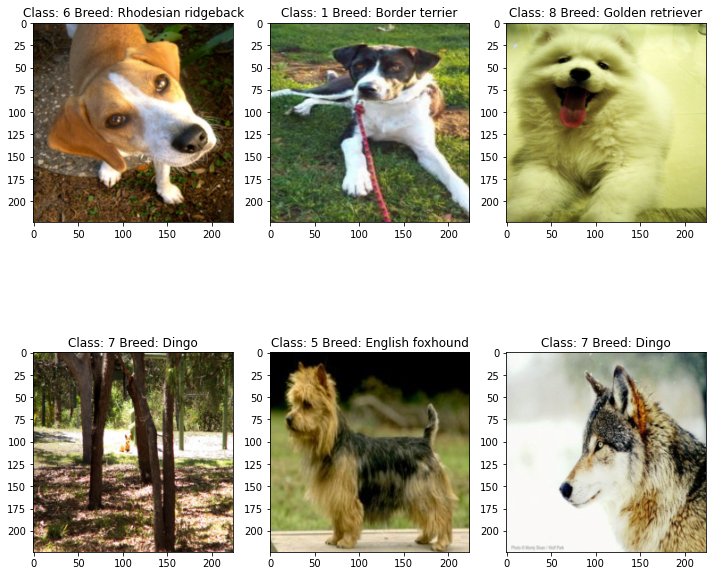

In [45]:
print('Train loader examples:\n')
grid_display_dataloader(train_dataloader, 2, 3, figsize=(10, 10))

## Build model

### Load model

- Lets check Resnet50 model with pretrained weights

In [46]:
model = models.resnet50(pretrained=True)

- Freeze pre-trained weigts 

In [47]:
for param in model.parameters():
    param.requires_grad = False

In [48]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

- We need to replace last layer with output equals to the number of our classes

In [49]:
n_inputs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(n_inputs, 256), 
                         nn.ReLU(), 
                         nn.Dropout(0.4), nn.Linear(256, 10))


In [50]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Define loss function and optimizer

- Since we are solving multiclassification problem it will be reasonable to use cross-entropy loss function 

- As optimizer lets choose commonly used Adam

In [51]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training model

In [52]:
def train(model, 
          criterion, 
          optimizer, 
          train_loader, 
          valid_loader, 
          n_epoch, save_file_name):
    
    
    history = []
    valid_loss_min = np.Inf

    for epoch in range(n_epoch):
        
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        # TRAINING PASS
        
        model.train()
        start = time()
        
        n_batch = 0
        for batch in train_loader:
            
            # Get images and targets from batch
            images, targets = batch['image'].to(device), batch['target'].to(device)
            
            # Clear gradient
            optimizer.zero_grad()
            
            # Forward pass 
            output = model(images)
            
            # Loss
            loss = criterion(output, targets)
            
            # Backward propagation
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            # Collect train loss for further average estimation 
            train_loss += loss.item()
            
            # Collect train accuracy for further average estimation 
            train_acc += accuracy(output, targets)
            
            n_batch += 1
        
        # Estimate average loss and accuracy
        train_loss = train_loss / n_batch
        train_acc = train_acc / len(train_loader)
            
        
        # VALIDATION PASS
        
        with torch.no_grad():
            model.eval()
        
            n_batch = 0
            for batch in valid_loader:
                
                # Get images and targets from batch
                images, targets = batch['image'].to(device), batch['target'].to(device)

                # Predictions 
                output = model(images)
                
                # Validation Loss
                loss = criterion(output, targets)

                # Collect validation loss for further average estimation 
                valid_loss += loss.item()
            
                # Collect train accuracy for further average estimation 
                valid_acc += accuracy(output, targets)
                n_batch += 1

        # Estimate average loss and accuracy

        valid_loss = valid_loss / n_batch
        valid_acc = valid_acc / len(valid_loader)
            
            
        history.append([train_loss, valid_loss, train_acc, valid_acc])
        
        # Save model if validation loss decreases
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_file_name)
            valid_loss_min = valid_loss

        
        # Print  progress
        print("Epoch: (%d) | Train Loss:%f | Train Acc:%f | Valid Loss:%f | Valid Acc:%f | Time elapsed:%.2f s" % 
              (epoch+1, train_loss, train_acc, valid_loss, valid_acc, time()-start))

            
    history = pd.DataFrame(history, columns=['train_loss', 
                                             'valid_loss', 
                                             'train_acc',
                                             'valid_acc'])
        
    return model, history

In [55]:
model, history = train(model, criterion, optimizer, 
                       train_dataloader, valid_dataloader, 
                       n_epoch=10, 
                       save_file_name='../models/history/model_state.cpkt')

Epoch: (1) | Train Loss:0.414962 | Train Acc:0.876320 | Valid Loss:0.308245 | Valid Acc:0.895937 | Time elapsed:86.42 s
Epoch: (2) | Train Loss:0.298923 | Train Acc:0.904379 | Valid Loss:0.216606 | Valid Acc:0.927107 | Time elapsed:85.18 s
Epoch: (3) | Train Loss:0.284632 | Train Acc:0.912852 | Valid Loss:0.210578 | Valid Acc:0.928004 | Time elapsed:85.28 s
Epoch: (4) | Train Loss:0.262165 | Train Acc:0.913072 | Valid Loss:0.175125 | Valid Acc:0.942510 | Time elapsed:85.39 s
Epoch: (5) | Train Loss:0.244671 | Train Acc:0.922975 | Valid Loss:0.188532 | Valid Acc:0.937016 | Time elapsed:85.08 s
Epoch: (6) | Train Loss:0.226782 | Train Acc:0.924076 | Valid Loss:0.204096 | Valid Acc:0.928952 | Time elapsed:85.41 s
Epoch: (7) | Train Loss:0.261221 | Train Acc:0.912852 | Valid Loss:0.168409 | Valid Acc:0.945222 | Time elapsed:85.50 s
Epoch: (8) | Train Loss:0.238056 | Train Acc:0.923305 | Valid Loss:0.204345 | Valid Acc:0.930917 | Time elapsed:85.42 s
Epoch: (9) | Train Loss:0.306392 | Train

- Check losses and accuracy scores for train and validation datasets 

(0.8, 1.0)

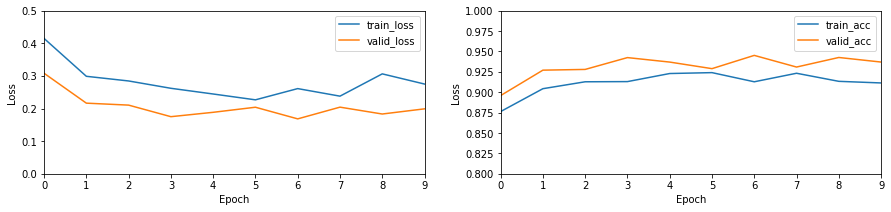

In [71]:
history

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

history.plot( y='train_loss', ax=ax[0])
history.plot( y='valid_loss', ax=ax[0])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

history.plot( y='train_acc', ax=ax[1])
history.plot( y='valid_acc', ax=ax[1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

ax[0].set_xlim(0, 9)
ax[0].set_ylim(0, 0.5)
ax[1].set_xlim(0, 9)
ax[1].set_ylim(0.8, 1)

- Losses is pretty stable toward the end of training and accuracy is pretty high too

- Check confusion matrix

In [75]:
confmat = ConfusionMatrix(num_classes=10)

with torch.no_grad():
    model.eval()
    
    y_true = []
    y_pred = []
    
    for batch in valid_dataloader:

        # Get images and targets from batch
        images, targets = batch['image'].to(device), batch['target'].to(device)
        
        y_true.extend(targets.cpu().numpy())
        
        # Predictions 
        outputs = model(images)
        
        predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.indices.cpu().numpy())

cf_matrix = confmat(torch.tensor(y_true), torch.tensor(y_pred))

<AxesSubplot:>

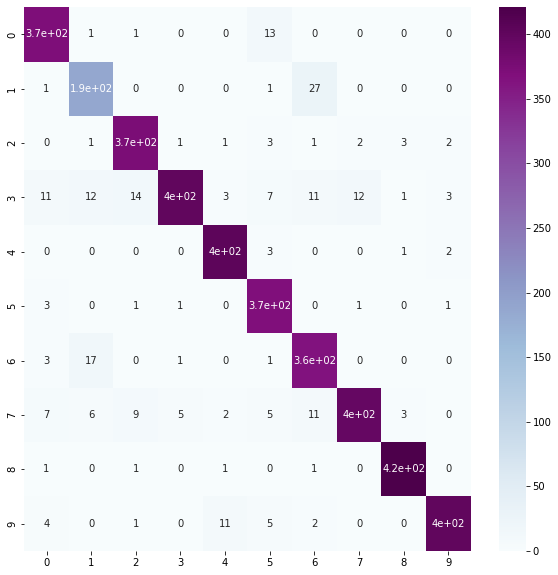

In [76]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(cf_matrix, annot=True, cmap="BuPu")

- Confusion matrix looks good, even though class 1 was inbalanced there seem to be no problem in its identification

- Check single predictions on validation set

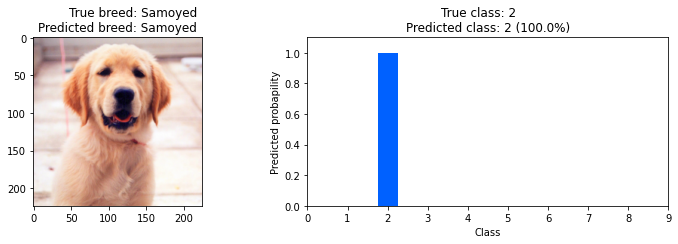

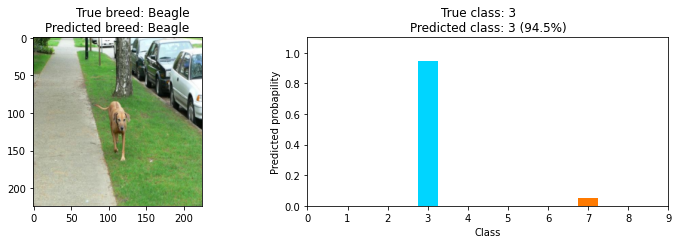

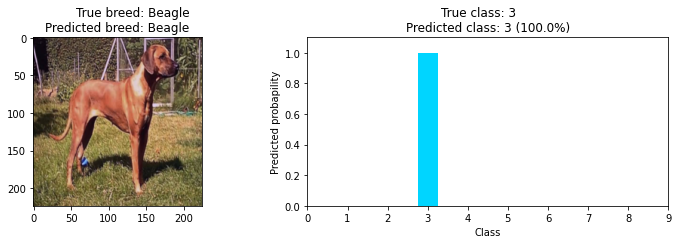

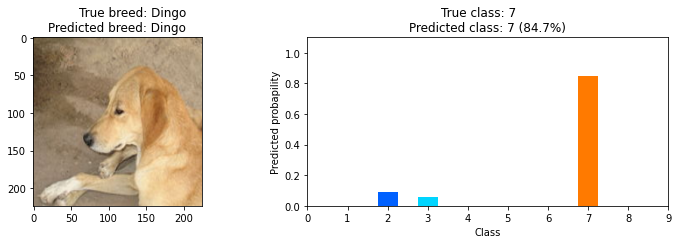

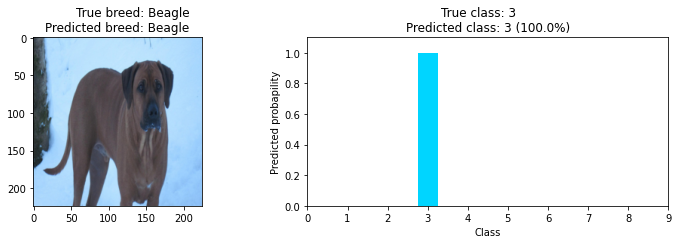

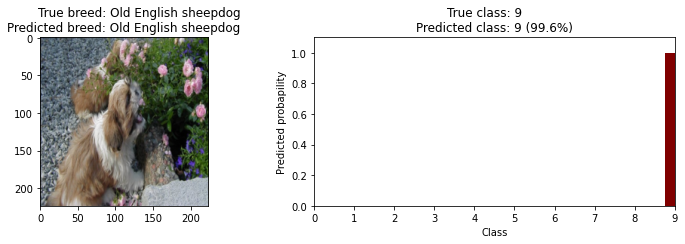

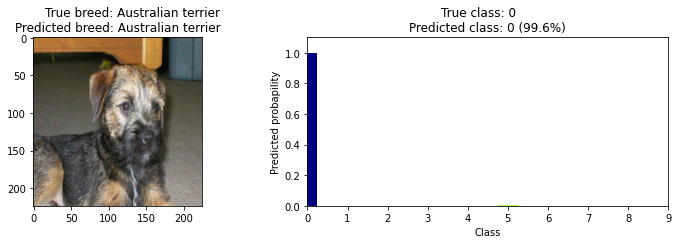

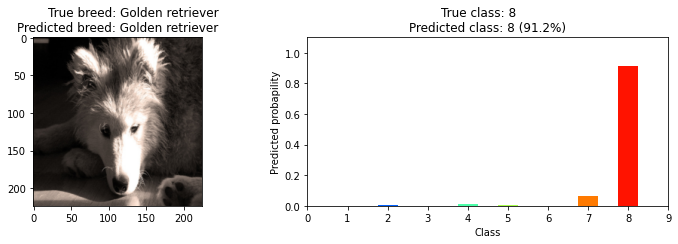

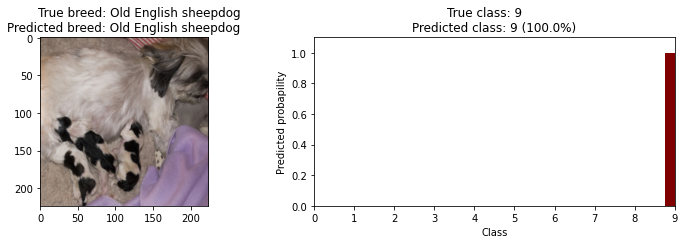

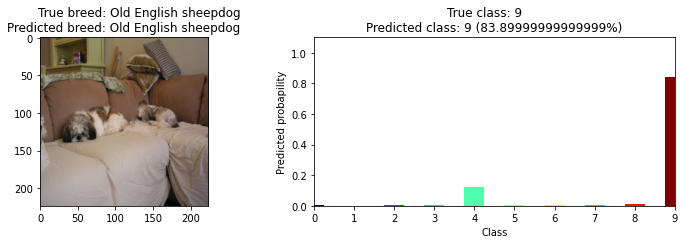

In [85]:
for i in range(10):
    random_idx = int(np.random.uniform(0, len(valid_dataset)))
    show_single_prediction(model, valid_dataset[random_idx])


- Overall prediction results seems good